In this notebook, we show our data processing steps from the paper information offered by the APS to the main data we use in the following analyses.  
The raw data can be requested at https://journals.aps.org/datasets, where the introduction of data can also be acquired. The main data we use in the following analyses include two tables. One includes the scientific impact of each author's each publication and the other includes the exploratory metrics of each author's each publication.   
In the [structuralize raw data](#structuralize-raw-data) section, we process the raw json files and create a table of paper information.  
In the [count five-year citations](#count-five-year-citations) section, we count the citations each paper received in the five years after its publication, then we take the log-citations as our evaluation metrics of scientific impact.  
In the [assign areas and topics](#assign-areas-and-topics) section, we assign the PACS code to each paper.  
In the [name disambiguation](#name-disambiguation) section, we perform name disambiguation for authors using their public information. Thus we can have an accurate publication list for each author.  
In the [EP & ED](#EP-&-ED) section, we show our calculation process of exploratory propensity (EP) and exploratory distance (ED) based on PACS codes.  
In the [Select Scientists](#select-Scientists) section, we select authors who have at least 10 publications as our study objects.

# Process Data
In this section, 

In [166]:
import statistics
import sys
import datetime
import os
import json
import scipy.io as scio
import pickle
import math
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tqdm
from collections import Counter
from itertools import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)


def save_pkl(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)


def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


print(os.listdir())

['5_1_PSW.R', '6_temporal_perspectives.ipynb', 'draw', '1_data_processing.ipynb', '3_sample_scientist.ipynb', '2_interplays.ipynb', '4_regression_result.ipynb', '.ipynb_checkpoints', '5_2_PSW_result.ipynb', '__pycache__']


## structuralize raw data
The raw data are json files of each publication, in this section, we process the raw json files and create a table of paper information.

In [34]:
paper_doi = []
authors_name = []
dates = []
paper_type = []
# the path where you put the raw file from APS
for pairs in tqdm.tqdm(os.walk("/public/aps/raw_data/aps-dataset-metadata-2020/", topdown=False)):
    root = pairs[0]
    files = pairs[2]
    for name in files:
        path = os.path.join(root, name)
        author_name = []
        with open(path, 'r') as f:  # read json files
            data = json.load(f)

            date_list = list(map(int, data['date'].split('-')))
            date = datetime.date(date_list[0], date_list[1], date_list[2])
            dates.append(date)

            paper_doi.append(data['id'])

            if 'articleType' in data.keys():
                paper_type.append(data['articleType'])
            else:
                paper_type.append(None)

            if 'authors' in data.keys():
                for i in range(len(data['authors'])):
                    author_name.append(data['authors'][i]['name'])
            else:
                author_name = None
            authors_name.append(author_name)

1031it [11:21,  1.51it/s]


In [35]:
meta_paper_data = pd.DataFrame({
    'paperDoi': paper_doi,
    'authorName': authors_name,
    'date': dates,
    'type': paper_type
})
# save_pkl('../data/processing_data/meta_paper_data.pkl', meta_paper_data) # if you want to save the file, uncomment the line:)

In [36]:
meta_paper_data.date.min(), meta_paper_data.date.max(), len(meta_paper_data)

(datetime.date(1893, 7, 1), datetime.date(2020, 12, 31), 678961)

## count five-year citations
APS provides the publications' citation pairs for us. We utilize the pairs to count the logarithm of the number of citations each paper received within five years after it was published (5-year log-citations, $\log c_5$) and merge it with meta_paper_data we get above.

In [37]:
# For each citation pair, add the publication date for both citing paper and cited paper
# meta_paper_data = load_pkl('./meta_paper_data.pkl') # if you want to read the file, uncomment the line:)
doi_date = dict(zip(meta_paper_data.paperDoi, meta_paper_data.date))
# the path where you put the raw file from APS
cit_pair = pd.read_csv('/public/aps/raw_data/aps-dataset-citations-2020.csv')
cit_pair_with_time = pd.merge(cit_pair, meta_paper_data[['paperDoi', 'date']].rename(columns={
                              'paperDoi': 'citing_doi', 'date': 'citing_pubdate'}), on='citing_doi', how='left').drop_duplicates()
cit_pair_with_time = pd.merge(cit_pair_with_time, meta_paper_data[['paperDoi', 'date']].rename(
    columns={'paperDoi': 'cited_doi', 'date': 'cited_pubdate'}), on='cited_doi', how='left').drop_duplicates()
cit_pair_with_time = cit_pair_with_time.dropna().reset_index(
    drop=True)  # delete record without time

In [38]:
# Count the list of references and citations for each paper
n = 5  # time windows for citation count
citation_dict = {}
reference_dict = {}

for i in tqdm.tqdm(range(len(cit_pair_with_time))):
    # for each citation pair
    cited_pub_i = cit_pair_with_time.cited_pubdate.iloc[i] # publication date of cited paper
    citing_pub_i = cit_pair_with_time.citing_pubdate.iloc[i] # publication date of citing paper
    delta = citing_pub_i-cited_pub_i 
    cited_doi_i = cit_pair_with_time.cited_doi.iloc[i] # DOI of cited paper
    citing_doi_i = cit_pair_with_time.citing_doi.iloc[i] # DOI of citing paper

    # for cited list
    if (delta >= datetime.timedelta(days=0)) & (delta <= datetime.timedelta(days=n*365)):  # 5years= 365*5 days
        if cited_doi_i in citation_dict.keys():
            citation_dict[cited_doi_i].add(citing_doi_i)
        else:
            citation_dict[cited_doi_i] = set([citing_doi_i])

    # for reference list
    if citing_doi_i in reference_dict.keys():
        reference_dict[citing_doi_i].add(cited_doi_i)
    else:
        reference_dict[citing_doi_i] = set([cited_doi_i])

100%|██████████| 8767868/8767868 [05:31<00:00, 26412.55it/s]


In [39]:
# add number of citations to meta_paper_data
meta_paper_data = meta_paper_data.drop_duplicates(subset=['paperDoi', 'date'])
citations = []
references = []
cit_count = []
ref_count = []
for i in tqdm.tqdm(range(len(meta_paper_data))):
    paperdoi = meta_paper_data.paperDoi.iloc[i]
    if paperdoi in citation_dict.keys():
        citations.append(citation_dict[paperdoi])
        cit_count.append(len(citation_dict[paperdoi]))
    else:
        citations.append(set([]))
        cit_count.append(0)
    if paperdoi in reference_dict.keys():
        references.append(reference_dict[paperdoi])
        ref_count.append(len(reference_dict[paperdoi]))
    else:
        references.append(set([]))
        ref_count.append(0)

meta_paper_data_2 = meta_paper_data.copy()
meta_paper_data_2['citations'] = citations
meta_paper_data_2['citCount'] = cit_count
meta_paper_data_2['references'] = references
meta_paper_data_2['refCount'] = ref_count

meta_paper_data_2 = meta_paper_data_2.drop_duplicates(
    subset=['paperDoi', 'date']).reset_index(drop=True)
# visualization of mean log c5 of each year
meta_paper_data_2['logCit'] = [np.log(i+1)
                               for i in meta_paper_data_2['citCount']]
save_pkl('../data/processing_data/meta_paper_data_2.pkl', meta_paper_data_2)

100%|██████████| 678916/678916 [00:07<00:00, 91951.52it/s]


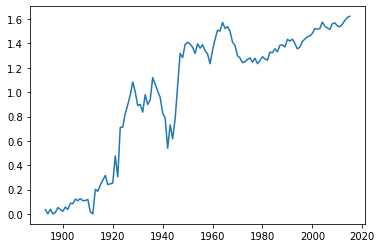

In [75]:
meta_paper_data_2['year'] = [i.year for i in meta_paper_data_2['date']]
plt.plot(meta_paper_data_2.groupby('year').logCit.mean()[:-5])

## assign areas and topics
APS provides the PACS codes of each paper for us. We process the '.txt' file and then add the topics information for each paper to our 'meta_paper_data' table.

In [95]:
PACS = pd.read_csv('/public/aps/raw_data/PACS.txt', keep_default_na=False) # the txt file provided by the APS
def get_genre(name):
    '''
    Input: 'PACS1~5' for different PACS codes of all papers, '1' for the first, '5' for the last.
    Output: a PACS codes list
    '''
    PACS_code = []
    for i in tqdm.tqdm(range(len(PACS))):
        p_code = re.match(r'((.*)([0-9]{4})(.*))', str(
            PACS[name].iloc[i]).replace('.', '').replace(' ', '').replace(':', ''))
        if p_code:
            if p_code.group(1)[:2].isdigit():
                PACS_code.append(p_code.group(1)[:6].replace(
                    '−', '-').replace('–', '-'))
            else:
                PACS_code.append(None)
        else:
            PACS_code.append(None)
    return PACS_code

# all PACS codes
genres_set = set(get_genre('PACS1') + get_genre('PACS2') +
                 get_genre('PACS3') + get_genre('PACS4') + get_genre('PACS5'))


PACS1 = get_genre('PACS1')
PACS2 = get_genre('PACS2')
PACS3 = get_genre('PACS3')
PACS4 = get_genre('PACS4')
PACS5 = get_genre('PACS5')

# build a dict of DOI-PACSlist
genres_list = []
for i in tqdm.tqdm(range(len(PACS))):
    gl = [PACS1[i], PACS2[i], PACS3[i], PACS4[i], PACS5[i]]
    while None in gl:
        gl.remove(None)
    genres_list.append(gl)

doi_cor_genre = dict(zip(PACS.DOI, genres_list))
len(doi_cor_genre)
# doi_cor_genre['10.1103/PhysRevA.60.R2614'] = ['0365Bz', '4250Dv', '89701c']
# doi_cor_genre['10.1103/PhysRevB.66.104415'] = ['7570Pa', '71301h', '78202e']
# doi_cor_genre['10.1103/PhysRevE.65.026128'] = ['05202y', '04402b', '05901m']

100%|██████████| 441340/441340 [00:00<00:00, 782248.38it/s]


441340

In [65]:
meta_paper_data_2 = load_pkl('../data/processing_data/meta_paper_data_2.pkl')

In [96]:
# add PACS codes to meta_paper_data
genres = []
for i in tqdm.tqdm(range(len(meta_paper_data_2))):
    if meta_paper_data_2.paperDoi.iloc[i] in doi_cor_genre.keys():
        genres.append(doi_cor_genre[meta_paper_data_2.paperDoi.iloc[i]])
    else:
        genres.append(None)

meta_paper_data_3 = meta_paper_data_2.copy()
meta_paper_data_3['genres'] = genres

100%|██████████| 678916/678916 [00:10<00:00, 64393.94it/s]


In [97]:
save_pkl('../data/processing_data/meta_paper_data_3.pkl', meta_paper_data_3)

## name disambiguation
In this section we perform name disambiguation for authors using their public information. 
1. We process the json files to a dataframe with affiliation information. 
2. We treat each author from any publication as if each were unique. 
3. We merge the similar authors through several criteria.
4. We build a dataframe of information of each author's each publication, using the merged author data and paper data we get above.

### process data

In [47]:
# structuralize the json file, include affiliation information
paper_doi = []
authors_name = []
dates = []
paper_affs = []
for pairs in tqdm.tqdm(os.walk("/public/aps/raw_data/aps-dataset-metadata-2020/", topdown=False)):
    root = pairs[0]
    files = pairs[2]
    for name in files:
        path = os.path.join(root, name)
        author_name = []
        with open(path, 'r') as f:  # read json files
            data = json.load(f)

            # split features and store them in list
            date_list = list(map(int, data['date'].split('-')))
            date = datetime.date(date_list[0], date_list[1], date_list[2])
            dates.append(date)

            paper_doi.append(data['id'])

            if 'authors' in data.keys():
                for i in range(len(data['authors'])):
                    if 'affiliationIds' in data['authors'][i].keys():
                        author_name.append(
                            (data['authors'][i]['name'], data['authors'][i]['affiliationIds']))
                    else:
                        author_name = None
                        break

            else:  # some authors do not have name
                author_name = None
            authors_name.append(author_name)

            if 'affiliations' in data.keys():
                aff_dict = {}
                for aff in data['affiliations']:
                    aff_dict[aff['id']] = aff['name']
                paper_affs.append(aff_dict)
            else:
                paper_affs.append(None)

1031it [11:17,  1.52it/s]


In [48]:
meta_data = pd.DataFrame({
    'paperDoi': paper_doi,
    'authorName': authors_name,
    'date': dates,
    'paperAff': paper_affs})

### process procedure
We build a table of authors' information, treating each author from any publication as if each were unique. Then we divide the authors into different groups, authors in each group have same last name and initial of first name. Within each group we merge similar authors through the following steps:
1. For each iteration, we merge authors who(1) are in similar affiliation,(2) cite each other, or (3) have co-authors.
2. After one iteration, we update the data by (1) merging same authors and (2) deleting merged records.
3. In the later period of the merging procedure, when there is no update through the first three criteria, we merge authors have publications in the same journal (which means they have similar study field) and have same whole names (which means they are most probably the same person). 
4. Then we merge authors who cite each other or have co-authors for several iterations, until there is no new update. 
(Note that for each merge we make sure there is no conflict between author information.)
Finally we get a dataframe of each author's publications.

In [49]:
meta_data = meta_data.dropna().reset_index(drop=True)

In [50]:
# author - paper information
aid = []
author_name = []
alter_name = []
doi = []
ref_set = []
coauthor_set = []
author_aff = []
first_letter = []
last_name = []
name_split = []
gid = []
journal = []
raw_name = []
count = 0
test = 0
for i in tqdm.tqdm(range(len(meta_data))):
    # for each publication
    p_doi = meta_data.paperDoi.iloc[i]
    authors_info = meta_data.authorName.iloc[i]
    pap_aids = [str(count+i) for i in range(len(authors_info))]
    paper_aff_dict = meta_data.paperAff.iloc[i]
    
    for a_info in authors_info:
        # for each author
        aname = a_info[0].lower().strip().replace('_','')
        if aname[0] in set(['\n', '\u2008', '<', '\xa0', '.', '[', '(']):
            test+=1
            break
        aid.append(set([str(count)]))
        gid.append(str(count))
        aname_fix = re.sub(u"\\(.*\\)|\\{.*}|\\[.*]", "", aname).replace(', jr.','').replace(' jr.','').strip()
        author_name.append(aname_fix)
        alter_name.append(set([aname_fix]))
        raw_name.append(a_info[0])
        sp_list = aname_fix.split()
        name_split.append(sp_list)
        first_letter.append(aname_fix[0])
        last_name.append(sp_list[-1])
        
        aff_name = []
        for i in a_info[1]:
            if i in paper_aff_dict:
                aff_name.append(paper_aff_dict[i].lower()) 
        author_aff.append(set(aff_name))
        
        doi.append(set([p_doi]))
        journal.append(set([re.sub('[\d,./]', '', p_doi)]))
        if p_doi in reference_dict.keys():
            ref_set.append(reference_dict[p_doi])
        else:
            ref_set.append(set([]))
        coauthor_set.append(set(pap_aids)-set([str(count)]))
        count += 1

100%|██████████| 652703/652703 [01:15<00:00, 8634.37it/s] 


In [51]:
author_paper = pd.DataFrame({
    'gid': gid,
    'aid': aid,
    'rawName': raw_name,
    'authorName': author_name,
    'firstLetter': first_letter,
    'lastName': last_name,
    'alterName': alter_name,
    'nameSplit': name_split,
    'doi': doi,
    'journal': journal,
    'refSet': ref_set,
    'coauthorSet': coauthor_set,
    'authorAff': author_aff,
})

In [52]:
sim_group = {}
for key, value in tqdm.tqdm(author_paper.groupby(['firstLetter', 'lastName'])):
    sim_group[key] = value

100%|██████████| 254531/254531 [00:49<00:00, 5149.37it/s]  


In [53]:
meta_data = load_pkl('../data/processing_data/meta_data.pkl')
# all affiliation names
global aff_names
aff_names = ''
for i in tqdm.tqdm(range(len(meta_data))):
    try:
        for j in list(meta_data['paperAff'].iloc[i].values()):
            term_list = j.replace(',', '').replace('.', '').lower().split()
            term_str = ' '.join(list(set(term_list)))
            aff_names += term_str
            aff_names += ' '
    except:
        continue

100%|██████████| 678959/678959 [00:12<00:00, 53869.06it/s]


In [54]:
# several functions for calculating cosine similarity with TF-IDF
def termFrequency(term, document):
    return document.count(term) / float(len(document))


def computeTf(document):
    sentence = document.replace(',', '').replace('.', '').lower().split()
    tf = dict.fromkeys(set(sentence), 0)
    for word in sentence:
        tf[word] = termFrequency(word, sentence)
    return tf


def inverseDocumentFrequency(term, documents):
    global idf_dict
    if term in idf_dict.keys():
        df = idf_dict[term]
    else:
        df = documents.count(term)
        idf_dict[term] = df
    return math.log(float(1348385) / df)


def computeIdf(document, documents):
    idf_dict = {}
    sentence = document.replace(',', '').replace('.', '').lower().split()
    for word in sentence:
        idf_dict[word] = inverseDocumentFrequency(word, documents)
    return idf_dict


def tfIdf(aff_name, aff_names):
    vec = {}
    vec_tf = computeTf(aff_name)
    vec_idf = computeIdf(aff_name, aff_names)
    for key in vec_tf.keys():
        vec[key] = vec_tf[key]*vec_idf[key]
    return vec


def calSim(aff_name1, aff_name2, aff_names):
    '''
    calculate the cosine similarity of two affiliation names
    '''
    global idf_dict

    tf_idf_1 = tfIdf(aff_name1, aff_names)
    tf_idf_2 = tfIdf(aff_name2, aff_names)
    vec1 = []
    vec2 = []

    for key in (set(tf_idf_1.keys()).union(set(tf_idf_2.keys()))):
        if key in tf_idf_1.keys():
            vec1.append(tf_idf_1[key])
        else:
            vec1.append(0)
        if key in tf_idf_2.keys():
            vec2.append(tf_idf_2[key])
        else:
            vec2.append(0)

    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    sim = vec1.dot(vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    return sim

In [55]:
def isSameNameSet(nameset1, nameset2):
    '''
    Determine whether the two sets of names refer to the same person.
    If the two sets have same full name, return 1; else return 2. 
    If the two sets repel each other, return False.
    '''
    flag = '2'
    for name1 in nameset1:
        for name2 in nameset2:
            if isSameName(name1, name2):
                if ('1' in isSameName(name1, name2)):  # same full name
                    return '1'
    for name1 in nameset1:
        for name2 in nameset2:
            if not bool(isSameName(name1, name2)):
                return False
    return flag


def isSameName(name1, name2):
    global aisian_names
    '''
    Determine whether two names refer to the same person.
    If the two names are all full names and totally the same, return 1. 
    If one of the two names are in abbreviation and both of them compatible with each other, return 2. 
    If the two names repel each other, return False.
    '''
    name1_list = re.findall(r'[^\-\s]+', name1.replace('.', '. '))
    name2_list = re.findall(r'[^\-\s]+', name2.replace('.', '. '))

    flag = '1'  # same full name
    if (len(name1_list) == len(name2_list)):
        for i in range(len(name1_list)):
            part1 = name1_list[i]
            part2 = name2_list[i]
            if ('.' not in part1) & ('.' not in part2):
                if part1 != part2:  # Names without abbreviations need to have the same name
                    return False
            else:  # Names with abbreviations only need to have the same first letter of the first name
                if part1[0] != part2[0]:
                    return False
                else:
                    flag = '2'
    else:
        flag = '2'
        for i in range(min(len(name1_list), len(name2_list))):
            part1 = name1_list[i]
            part2 = name2_list[i]
            if ('.' not in part1) & ('.' not in part2):
                if part1 != part2:
                    return False
            else:
                if part1[0] != part2[0]:
                    return False
    return flag

In [56]:
# Determine whether athors have same institution
def ifSameAff():
    global aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):
        stop_set = []

        for j in range(i+1, len(aid_list)):
            if isSameNameSet(aname_list[i], aname_list[j]):

                if authorAff_list[i] & authorAff_list[j]:
                    update_list(i, j)
                    stop_set.append(j)

        del_list(stop_set)

        i += 1

    return True

# Determine whether the authors' publication journals are similar


def ifSameJournal():
    global aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):
        stop_set = []

        for j in range(i+1, len(aid_list)):
            if isSameNameSet(aname_list[i], aname_list[j]):

                if bool(journal_list[i] & journal_list[j]):
                    update_list(i, j)
                    stop_set.append(j)

        del_list(stop_set)

        i += 1

    return True

# Determine whether the authors' names are similar


def ifSimilar(sim_thres):
    global idf_dict, aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):

        stop_set = []

        for j in range(i+1, len(aid_list)):

            if isSameNameSet(aname_list[i], aname_list[j]):

                sims = []
                for aff_name1 in authorAff_list[i]:
                    for aff_name2 in authorAff_list[j]:
                        sims.append(calSim(aff_name1, aff_name2, aff_names))

                if len(sims) != 0:
                    if max(sims) >= sim_thres:
                        update_list(i, j)
                        stop_set.append(j)

        del_list(stop_set)

        i += 1

    return True

# Determine whether the coauthors are similar


def ifCoauthor():

    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):
        stop_set = []
        for j in range(i+1, len(aid_list)):

            if isSameNameSet(aname_list[i], aname_list[j]):

                if coauthorSet_list[i] & coauthorSet_list[j]:

                    update_list(i, j)
                    stop_set.append(j)

        del_list(stop_set)

        i += 1

    return True

# determines whether the authors cite each others publications


def ifrefEachOther():
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):

        stop_set = []

        for j in range(i+1, len(aid_list)):

            if isSameNameSet(aname_list[i], aname_list[j]):

                if (doi_list[j] & refSet_list[i]) & (doi_list[i] & refSet_list[j]):
                    update_list(i, j)
                    stop_set.append(j)
        del_list(stop_set)

        i += 1
    return True

# determine whether the authors have same whole name (without abbreviations in their names).


def ifSameWholeName():
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i < len(aid_list):

        stop_set = []

        for j in range(i+1, len(aid_list)):

            if isSameNameSet(aname_list[i], aname_list[j]) == '1':

                update_list(i, j)
                stop_set.append(j)

        del_list(stop_set)

        i += 1
    return True

In [57]:
def update_list(i, j):
    '''
    after each iteration, update the disambiguation list:
    merge the records identified as one author.
    '''
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list
    aid_list[i] = aid_list[i] | aid_list[j]
    aname_list[i] = aname_list[i] | aname_list[j]
    doi_list[i] = doi_list[i] | doi_list[j]
    refSet_list[i] = refSet_list[i] | refSet_list[j]

    #  update_author
    if gid_list[j] in co_update_dict.keys():
        co_update_dict[gid_list[j]].update(aid_list[i])
    else:
        co_update_dict[gid_list[j]] = aid_list[i]
    coauthorSet_list[i] = coauthorSet_list[i] | coauthorSet_list[j]
    authorAff_list[i] = authorAff_list[i] | authorAff_list[j]
    journal_list[i] = journal_list[i] | journal_list[j]


def del_list(stop_set):
    '''
    after each iteration, update the disambiguation list:
    delete the merged records.
    '''
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list
    aid_list = [aid_list[k]
                for k in range(0, len(aid_list), 1) if k not in stop_set]
    aname_list = [aname_list[k]
                  for k in range(0, len(aname_list), 1) if k not in stop_set]
    gid_list = [gid_list[k]
                for k in range(0, len(gid_list), 1) if k not in stop_set]
    doi_list = [doi_list[k]
                for k in range(0, len(doi_list), 1) if k not in stop_set]
    refSet_list = [refSet_list[k]
                   for k in range(0, len(refSet_list), 1) if k not in stop_set]
    coauthorSet_list = [coauthorSet_list[k] for k in range(
        0, len(coauthorSet_list), 1) if k not in stop_set]
    authorAff_list = [authorAff_list[k] for k in range(
        0, len(authorAff_list), 1) if k not in stop_set]
    journal_list = [journal_list[k]
                    for k in range(0, len(journal_list), 1) if k not in stop_set]

In [60]:
global co_update_dict, idf_dict, pair_set_dict
idf_dict = {}
# idf_dict = load_pkl('../data/processing_data/idf_dict.pkl')
co_update_dict = {}
pair_set_dict = {}

In [ ]:
aid = []
aname = []
gid = []
doi = []
refSet = []
coauthorSet = []
authorAff = []

SIM_THRESHOLD = 0.15
count = 0

loop_group = {}

for key in tqdm.tqdm(sim_group.keys()):

    df = sim_group[key]

    if count % 20000 == 0:
        print('key=', key)

    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, journal_list
    # dynamic update info
    aid_list = list(df.aid)
    aname_list = list(df.alterName)
    gid_list = list(df.gid)
    doi_list = list(df.doi)
    refSet_list = list(df.refSet)
    coauthorSet_list = list(df.coauthorSet)
    journal_list = list(df.journal)

    for idx in range(len(coauthorSet_list)):
        if coauthorSet_list[idx] & co_update_dict.keys():
            for item in coauthorSet_list[idx] & co_update_dict.keys():
                coauthorSet_list[idx].update(co_update_dict[item])

    authorAff_list = list(df.authorAff)

    if len(df) != 1:

        loop = True
        while loop:
            df_length = len(aid_list)

            ifSameAff()
            ifSimilar(0.15)

            ifrefEachOther()
            ifCoauthor()
            if (len(aid_list) == df_length):
                loop = False

        ifSameWholeName()
        ifSameJournal()

        loop = True
        while loop:
            df_length = len(aid_list)
            ifrefEachOther()
            ifCoauthor()
            if (len(aid_list) == df_length):
                loop = False

    aid += aid_list
    aname += aname_list
    gid += gid_list
    doi += doi_list

    count += 1

  0%|          | 0/254531 [00:00<?, ?it/s]

key= ('0', 'acher')


  8%|▊         | 20001/254531 [1:11:35<19:34:38,  3.33it/s] 

key= ('a', 'schulze-bonhage')


 16%|█▌        | 40001/254531 [3:15:20<6:59:03,  8.53it/s]  

key= ('c', 'maurice')


 24%|██▎       | 60002/254531 [6:48:46<94:41:12,  1.75s/it] 

key= ('e', 'choubabi')


 24%|██▍       | 61140/254531 [7:02:36<11:58:25,  4.49it/s] 

In [63]:
author_paper_2 = pd.DataFrame({
    'aid': aid,
    'aname': aname,
    'gid': gid,
    'doi': doi,
})
author_paper_2.head()

,aid,aname,gid,doi
0,{1741261},{0. acher},1741261,{10.1103/PhysRevLett.85.2817}
1,{1741259},{0. vacus},1741259,{10.1103/PhysRevLett.85.2817}
2,"{106555, 107021}",{arif -uz -zaman},106555,"{10.1103/PhysRevD.11.2632, 10.1103/PhysRevD.11..."
3,{521604},{alfonso pérez a.},521604,{10.1103/PhysRevE.69.036121}
4,"{1527481, 2063010, 438021}","{alvo aabloo, a. aabloo}",438021,"{10.1103/PhysRevSTAB.17.103501, 10.1103/PhysRe..."
...,...,...,...,...
276174,"{1955331, 1672097, 1953455, 799111, 1269309, 1...",{p. k. mang},799111,"{10.1103/PhysRevLett.93.027002, 10.1103/PhysRe..."
276175,"{1413370, 1284086, 1014900, 842883, 1380886, 8...",{p. s. mangat},842883,"{10.1103/PhysRevB.44.6284, 10.1103/PhysRevB.41..."
276176,{1319901},{p. mangat},1319901,{10.1103/PhysRevB.46.13471}
276177,"{1528581, 1155428}","{p. mangelis, panagiotis mangelis}",1155428,"{10.1103/PhysRevB.94.165131, 10.1103/PhysRevB...."


### merge authors

In [98]:
paper_data = load_pkl('../data/processing_data/meta_paper_data_3.pkl')
author_paper_2 = load_pkl('../data/processing_data/author_paper_2.pkl')

In [101]:
author_paper_3 = author_paper_2
author_paper_3.doi = [str(i)[1:-1] for i in author_paper_2['doi']]
author_paper_3 = author_paper_3.drop(['doi'], axis=1).join(author_paper_3['doi'].str.split(
    ',', expand=True).stack().reset_index(level=1, drop=True).rename('paperDoi'))
author_paper_3['paperDoi'] = [i.strip().strip('\'')
                              for i in author_paper_3.paperDoi]

In [102]:
APS_author2DOI = author_paper_3[['gid', 'paperDoi']].rename(columns={
                                                            'gid': 'aid'})

In [ ]:
all_paper = pd.merge(paper_data[['paperDoi', 'date', 'genres', 'logCit', 'citCount']], APS_author2DOI, on=[
                     'paperDoi']).sort_values(by=['aid', 'date'], ascending=(True, True)).reset_index(drop=True)

In [ ]:
all_paper.describe()

,logCit,citCount
count,2333759.00,2333759.00
mean,1.47,6.60
std,1.01,12.80
min,0.00,0.00
25%,0.69,1.00
50%,1.39,3.00
75%,2.20,8.00
max,7.61,2018.00


In [ ]:
author_group = {}
for key, values in all_paper.groupby('aid'):
    author_group[key] = values

In [106]:
# select publications with PACS codes before 2016
author_group_5 = {}
for i in tqdm.tqdm(author_group.keys()):
    df = author_group[i]
    time_df = df[df.date < datetime.date(2016, 1, 1)]
    if (sum([bool(g) for g in time_df.genres]) == len(time_df)) & (len(time_df) > 0):
        author_group_5[i] = time_df

100%|██████████| 395678/395678 [02:59<00:00, 2198.78it/s]


In [107]:
aid = []
date = []
citCount = []
refCount = []
paperCount = []
genres = []
logCit = []
paperDoi = []
for a in tqdm.tqdm(author_group_5.keys()):
    df = author_group_5[a]
    aid.extend(df.aid)
    date.extend(df.date)
    paperDoi.extend(df.paperDoi)
    citCount.extend(df.citCount)
    paperCount.extend([len(df)]*len(df))
    genres.extend([list(set(i)) for i in df.genres])
    logCit.extend(df.logCit)

100%|██████████| 250031/250031 [01:28<00:00, 2816.37it/s]


In [108]:
author_paper = pd.DataFrame({
    'aid': aid,
    'date': date,
    'paperDoi': paperDoi,
    'citCount': citCount,
    'paperCount': paperCount,
    'genres': genres,
    'logCit': logCit,
})

In [109]:
save_pkl('../data/processing_data/author_paper.pkl', author_paper)

# EP & ED
First, we define the functions that are used to calculate the scientists' EP&ED.

Then, before calculating the ED, we construct a topic co-occurrence graph to calculate the distance between the topics.

Finally, we use the scientists' publication data to calculate exploratory metrics for each scientist's career.

## define function

In [133]:
def get_level(genres):
    '''
    Description: get areas based on topics.
    '''
    listlevel = []
    for i in genres:
        thislist = []
        for k in i:
            thislist.append(k[:2])
        thislist = list((thislist))
        listlevel.append(thislist)
    return listlevel


def matrix_jaccard(matrix, i, j):
    '''
    Description: calculate the similarity of any two topics
    Input: matrix: topic co-occurrence matrix, i:topic i, j:topic j
    Output: three similarity indicators of topic i and topic j: Jaccard, Weighted Jaccard, Weighted Overlap
    '''
    list1 = np.array(list(matrix[i, :]))
    list2 = np.array(list(matrix[j, :]))

    overset = ((np.array(list1) > 0) & (np.array(list2) > 0))

    sum_overset = np.sum(overset)

    if (sum_overset != 0):  # node i and node j have overlap node
        unweight = sum_overset / \
            np.sum((np.array(list1) > 0) | (np.array(list2) > 0))

        fenzi = np.sum(np.multiply(overset.astype('int'),
                       np.array(list1)+np.array(list2)))/2
        fenmu = (sum(list1) + sum(list2))

        weight = fenzi/fenmu
        overlap = fenzi/(fenmu - fenzi - matrix[i, j] - matrix[j, i])

        if (overlap < 0 or overlap > 1):
            print(i, j)

        return unweight, weight, overlap

    else:

        return 0, 0, 0


def formulate_similarity_distance(matrix):
    '''
    Description: get topic_distance = 1- topic_similarity
    '''
    for k in tqdm.tqdm(range(0, len(matrix))):
        matrix[k][k] = 0
        for k_2 in range(k+1, len(matrix)):
            matrix[k][k_2] = 1-matrix[k][k_2]
            matrix[k_2][k] = 1-matrix[k_2][k]
    return matrix

In [134]:
def explore_def(before_genres, now_genres, method):
    '''
    Description：determine whether the current paper is exploratory paper
    Input：before_genres: the area set of papers in look-back period, now_genres: the area set of current paper, method: we only use "loose" in our work
    Output：whether the current paper is exploratory paper
    '''
    if method == "loose":
        for g in now_genres:
            if g not in before_genres:
                return True
        return False
    else:
        for g in now_genres:
            if g in before_genres:
                return False
        return True


def distance_def(before_genres, now_genres):
    '''
    Description：calculate the paper distance of the current paper
    Input：before_genres: the topic set of papers in look-back period, now_genres: the topic set of current paper
    Output：the paper distance of the current paper
    '''
    result = 0
    count = 0
    for idx, now_genre in enumerate(now_genres):
        if now_genre not in num_genres:
            continue
        for before_genre in before_genres:
            if before_genre not in num_genres:
                continue
            dis = node_similarity['level1_overlap_matrix'][num_genres[before_genre],
                                                           num_genres[now_genre]]
            result += dis
            count += 1
    if count == 0:
        return np.nan
    return result/count

## bulid topic co_ocurrence graph

In [135]:
#load data
datapath = '../data/processing_data/'
author_paper = pd.read_pickle(datapath+"/author_paper.pkl")
author_paper['genres_level0'] = get_level(list(author_paper.genres))

# mapping of topics and areas
num_genres = list(set(list(chain(*list(author_paper.genres)))))
num_genres.sort()
num_genres = dict(zip(num_genres, range(0, len(num_genres))))

num_genres_level0 = list(set(list(chain(*list(author_paper.genres_level0)))))
num_genres_level0.sort()
num_genres_level0 = dict(
    zip(num_genres_level0, range(0, len(num_genres_level0))))

len(num_genres), len(num_genres_level0)

(5676, 73)

In [136]:
# get graph link weight
matrix = np.zeros([len(num_genres), len(num_genres)])
for i in tqdm.tqdm(author_paper.drop_duplicates(subset=['paperDoi']).genres):
    for k in range(0, len(i)):
        for k_2 in range(k+1, len(i)):
            matrix[num_genres[i[k]], num_genres[i[k_2]]] += 1/(len(i)-1)
            matrix[num_genres[i[k_2]], num_genres[i[k]]] += 1/(len(i)-1)
for i in range(0, len(matrix)):
    matrix[i][i] = 0

save_pkl(('../data/processing_data/occurence_matrix.pkl'), matrix)

100%|██████████| 377897/377897 [00:02<00:00, 183945.19it/s]


In [ ]:
# get weighted overlap indicator:
level1_overlap_matrix = np.zeros([len(num_genres), len(num_genres)])
for k in tqdm.tqdm(range(0, len(matrix))):
    for k_2 in range(k+1, len(matrix)):
        result = matrix_jaccard(matrix, k, k_2)
        level1_overlap_matrix[k, k_2] = result[2]
        level1_overlap_matrix[k_2, k] = result[2]

node_similarity = {}
node_similarity['level1_overlap_matrix'] = level1_overlap_matrix
node_similarity['level1_overlap_matrix'] = formulate_similarity_distance(
    node_similarity['level1_overlap_matrix'])

save_pkl('../data/processing_data/co_code_dis.pkl',
         [node_similarity['level1_overlap_matrix'], num_genres])

 21%|██        | 1192/5676 [1:42:08<6:19:43,  5.08s/it]

## calculate authors' EP&ED

In [152]:
node_similarity = {}
node_similarity['level1_overlap_matrix'], num_genres = load_pkl('../data/processing_data/co_code_dis.pkl')

In [153]:
author_paper['two_code_genres'] = author_paper['genres'].apply(lambda x: [
                                                               g[:2] for g in x])
author_paper['date'] = author_paper['date'].astype("str")

In [154]:
aids = []

last_year = []
this_year = []

bert_N1_distance = []
bert_N2_distance = []
bert_N3_distance = []
bert_N4_distance = []
bert_N5_distance = []
bert_N6_distance = []
bert_N7_distance = []
bert_N8_distance = []
bert_N9_distance = []
bert_N10_distance = []
bert_N11_distance = []
bert_N12_distance = []
bert_N13_distance = []
bert_N14_distance = []
bert_N15_distance = []
bert_distance = []

N1_ES = []
N2_ES = []
N3_ES = []
N4_ES = []
N5_ES = []
N6_ES = []
N7_ES = []
N8_ES = []
N9_ES = []
N10_ES = []
N11_ES = []
N12_ES = []
N13_ES = []
N14_ES = []
N15_ES = []
Loose_ES = []

In [155]:
# Calculate the EP and ED for each scientist throughout their career.
# Specifically, for each paper, we compare the paper to the paper during the look-back period. 
# See S2 in Supplementary Information for details of the process.
N = 15
for aid, personal_info in tqdm.tqdm(author_paper.groupby(by='aid')):

    before_N_genres = []
    before_N_genres_dis = []

    before_genres = set()
    before_genres_dis = []

    first_genre = personal_info['two_code_genres'].iloc[0]
    first_genre_dis = personal_info['genres'].iloc[0]

    before_N_genres.append(first_genre)
    before_N_genres_dis.append(first_genre_dis)

    for g in first_genre:
        before_genres.add(g)
    for g in first_genre_dis:
        before_genres_dis.append(g)

    for pid in range(1, len(personal_info)):
        aids.append(aid)

        last_year.append(personal_info['date'].iloc[pid - 1])
        this_year.append(personal_info['date'].iloc[pid])

        # EP
        now_N_genres = []
        for i in range(N):
            es_name = eval("N%d_ES" % (i+1))

            if len(before_N_genres) < i+1:
                es_name.append(explore_def(
                    now_N_genres, personal_info["two_code_genres"].iloc[pid], method="loose"))
            else:
                for g in before_N_genres[-(1+i)]:
                    now_N_genres.append(g)
                es_name.append(explore_def(
                    now_N_genres, personal_info["two_code_genres"].iloc[pid], method="loose"))
        Loose_ES.append(explore_def(
            before_genres, personal_info["two_code_genres"].iloc[pid], method="loose"))

        # ED
        now_N_genres = []
        for i in range(N):
            distance_name = eval("bert_N%d_distance" % (i+1))
            if len(before_N_genres_dis) < i+1:
                distance_name.append(distance_def(
                    now_N_genres, personal_info["genres"].iloc[pid]))
            else:
                for g in before_N_genres_dis[-(1+i)]:
                    now_N_genres.append(g)
                distance_name.append(distance_def(
                    now_N_genres, personal_info["genres"].iloc[pid]))
        bert_distance.append(distance_def(
            before_genres_dis, personal_info["genres"].iloc[pid]))

        # update topic and areas list
        before_N_genres.append(personal_info["two_code_genres"].iloc[pid])
        before_N_genres_dis.append(personal_info["genres"].iloc[pid])

        if len(before_N_genres) > N:
            before_N_genres.pop(0)
        if len(before_N_genres_dis) > N:
            before_N_genres_dis.pop(0)

        for g in personal_info['two_code_genres'].iloc[pid]:
            before_genres.add(g)
        for g in personal_info['genres'].iloc[pid]:
            before_genres_dis.append(g)

100%|██████████| 25237/25237 [06:44<00:00, 62.41it/s] 


In [156]:
# organise and save data
distance_info = pd.DataFrame(
    {
        "aid": aids,
        "lastDate": last_year,
        "thisDate": this_year,
        "N1_es_distance": bert_N1_distance,
        "N2_es_distance": bert_N2_distance,
        "N3_es_distance": bert_N3_distance,
        "N4_es_distance": bert_N4_distance,
        "N5_es_distance": bert_N5_distance,
        "N6_es_distance": bert_N6_distance,
        "N7_es_distance": bert_N7_distance,
        "N8_es_distance": bert_N8_distance,
        "N9_es_distance": bert_N9_distance,
        "N10_es_distance": bert_N10_distance,
        "N11_es_distance": bert_N11_distance,
        "N12_es_distance": bert_N12_distance,
        "N13_es_distance": bert_N13_distance,
        "N14_es_distance": bert_N14_distance,
        "N15_es_distance": bert_N15_distance,
        "All_es_distance": bert_distance,
        "N1_es": N1_ES,
        "N2_es": N2_ES,
        "N3_es": N3_ES,
        "N4_es": N4_ES,
        "N5_es": N5_ES,
        "N6_es": N6_ES,
        "N7_es": N7_ES,
        "N8_es": N8_ES,
        "N9_es": N9_ES,
        "N10_es": N10_ES,
        "N11_es": N11_ES,
        "N12_es": N12_ES,
        "N13_es": N13_ES,
        "N14_es": N14_ES,
        "N15_es": N15_ES,
        "Loose_es": Loose_ES,
    }
)
distance_info.to_pickle('../data/processing_data/avg_switch_distance_info.pkl')

In [157]:
distance_info.describe()

,N1_es_distance,N2_es_distance,N3_es_distance,N4_es_distance,N5_es_distance,N6_es_distance,N7_es_distance,N8_es_distance,N9_es_distance,N10_es_distance,N11_es_distance,N12_es_distance,N13_es_distance,N14_es_distance,N15_es_distance,All_es_distance
count,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00,533941.00
mean,0.53,0.54,0.54,0.55,0.55,0.55,0.55,0.55,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.57
std,0.22,0.20,0.20,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.37,0.40,0.41,0.41,0.42,0.42,0.42,0.42,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.44
50%,0.53,0.54,0.55,0.55,0.55,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.57,0.57,0.57
75%,0.70,0.69,0.68,0.68,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.70,0.70,0.70
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Select Scientists

In [198]:
author_paper = pd.read_pickle('../data/processing_data/author_paper.pkl')
distance_info = pd.read_pickle(
    '../data/processing_data/avg_switch_distance_info.pkl')

In [199]:
author_paper

,aid,date,paperDoi,citCount,paperCount,genres,logCit
0,100,2013-02-13,10.1103/PhysRevA.87.022315,4,3,"[0367Lx, 0365Yz, 0230Yy]",1.61
1,100,2014-12-03,10.1103/PhysRevA.90.062108,2,3,"[3380-b, 0365Xp]",1.10
2,100,2015-11-09,10.1103/PhysRevA.92.053411,3,3,"[0365Aa, 0365Xp, 0530Rt, 3280Qk]",1.39
3,1000,2004-09-13,10.1103/PhysRevB.70.121201,2,2,"[6172Ji, 7155Eq, 7670Hb, 6172Bb]",1.10
4,1000,2005-03-18,10.1103/PhysRevB.71.125209,1,2,"[6172Ji, 7670Hb, 7155Eq]",0.69
...,...,...,...,...,...,...,...
1077413,9998,2013-08-19,10.1103/PhysRevB.88.075424,2,3,"[7145Gm, 6146Df, 4270-a, 4120Cv]",1.10
1077414,9998,2014-10-17,10.1103/PhysRevB.90.165424,1,3,"[7322-f, 7867Bf, 7115Qe]",0.69
1077415,999853,1996-12-01,10.1103/PhysRevC.54.3051,0,2,"[2570Gh, 2570Jj]",0.00
1077416,999853,2013-07-11,10.1103/PhysRevC.88.014604,0,2,"[2540Sc, 8756bd, 2410-i]",0.00


In [200]:
first_date_dict = {}
paper_count_dict = {}
career_year_dict = {}
for aid, group in tqdm.tqdm(author_paper.groupby(by='aid')):
    first_date_dict[aid] = group['date'].iloc[0]
    paper_count_dict[aid] = len(group)
    career_year_dict[aid] = (group['date'].iloc[-1] -
                             group['date'].iloc[0]).days//365+1
    
author_paper["CareerYear"] = author_paper[["date", "aid"]].apply(
    lambda row: row.date - first_date_dict[row.aid], axis=1)
author_paper["CareerYear"] = author_paper["CareerYear"].apply(
    lambda x: x.days//365)+1
author_paper["paperCount"] = author_paper.apply(
    lambda x: paper_count_dict[x.aid], axis=1)
author_paper["cyCount"] = author_paper.apply(
    lambda x: career_year_dict[x.aid], axis=1)

100%|██████████| 250031/250031 [00:20<00:00, 12212.74it/s]


In [202]:
distance_info["CareerYear"] = distance_info[["thisDate", "aid"]].apply(
    lambda row: datetime.datetime.strptime(row.thisDate, '%Y-%m-%d').date() - first_date_dict[row.aid], axis=1)
distance_info["CareerYear"] = distance_info["CareerYear"].apply(
    lambda x: x.days//365)+1

In [203]:
numbers = []
for aid, presonal_info in distance_info.groupby(by='aid'):
    for i in range(2, len(presonal_info)+2):
        numbers.append(i)
distance_info['attempt_number'] = numbers
numbers = []
for aid, presonal_info in author_paper.groupby(by='aid'):
    for i in range(1, len(presonal_info)+1):
        numbers.append(i)
author_paper['attempt_number'] = numbers

In [204]:
author_paper = author_paper[author_paper.paperCount >= 10]
author_paper.aid.nunique()#shape

25237

In [206]:
author_paper.describe()

,citCount,paperCount,logCit,CareerYear,cyCount,attempt_number
count,559178.00,559178.00,559178.00,559178.00,559178.00,559178.00
mean,8.60,34.94,1.74,10.30,18.36,17.97
std,15.60,30.04,0.99,6.81,6.61,20.06
min,0.00,10.00,0.00,1.00,1.00,1.00
25%,2.00,16.00,1.10,5.00,13.00,6.00
50%,5.00,25.00,1.79,9.00,18.00,12.00
75%,10.00,43.00,2.40,15.00,23.00,22.00
max,2018.00,321.00,7.61,36.00,36.00,321.00


In [207]:
author_paper.to_csv('../data/regression/original_aps.csv', index=False)
distance_info.to_csv('../data/regression/switch.csv', index=False)